# Phase 5 — LightGBM & Robust Validation
**Inputs:** `data/processed/X_train_fe.csv`, `y_train_fe.csv`, `X_test.csv`, `y_test.csv`, `train_scaling_params.csv`  
**Steps:** (1) Time-aware expanding-window CV · (2) LightGBM + Optuna · (3) Three-way model comparison · (4) Probability calibration · (5) Threshold policy optimisation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ── Load engineered training data & scaling params ────────────────────────────
X_train_fe    = pd.read_csv("data/processed/X_train_fe.csv")
y_train_fe    = pd.read_csv("data/processed/y_train_fe.csv")
X_test_raw    = pd.read_csv("data/processed/X_test.csv")
y_test_raw    = pd.read_csv("data/processed/y_test.csv")
scaling_params = pd.read_csv("data/processed/train_scaling_params.csv").iloc[0]
MEAN_AMOUNT   = scaling_params["mean_amount"]
STD_AMOUNT    = scaling_params["std_amount"]

# ── Leakage-safe feature pipeline (identical to all prior phases) ─────────────
def apply_feature_pipeline(df_raw, y_raw, mean_amount, std_amount,
                            window_amount=100, window_fraud=500):
    df = df_raw.copy()
    df["Class"] = y_raw["Class"].values
    df = df.sort_values("Time").reset_index(drop=True)
    df["log_amount"]            = np.log1p(df["Amount"])
    df["amount_zscore_global"]  = (df["Amount"] - mean_amount) / std_amount
    amt_s = df["Amount"].shift(1)
    df["rolling_mean_amount"]   = amt_s.rolling(window_amount, min_periods=1).mean()
    df["rolling_std_amount"]    = amt_s.rolling(window_amount, min_periods=2).std(ddof=1)
    df["time_diff"]             = df["Time"] - df["Time"].shift(1)
    df["amount_deviation"]      = df["Amount"] - df["rolling_mean_amount"]
    std_safe = df["rolling_std_amount"].replace(0, np.nan)
    df["amount_zscore_rolling"] = df["amount_deviation"] / std_safe
    cls_s = df["Class"].shift(1)
    df["rolling_fraud_count_500"] = cls_s.rolling(window_fraud, min_periods=1).sum()
    df["rolling_fraud_rate_500"]  = cls_s.rolling(window_fraud, min_periods=1).mean()
    ENGINEERED = [
        "log_amount","amount_zscore_global","rolling_mean_amount","rolling_std_amount",
        "time_diff","amount_deviation","amount_zscore_rolling",
        "rolling_fraud_count_500","rolling_fraud_rate_500",
    ]
    all_cols   = list(df_raw.columns) + ENGINEERED
    out = df[all_cols + ["Class"]].dropna().reset_index(drop=True)
    return out[all_cols], out[["Class"]]

# ── Build test feature matrix (train scaling params only — no leakage) ────────
X_test_fe, y_test_fe = apply_feature_pipeline(X_test_raw, y_test_raw,
                                               MEAN_AMOUNT, STD_AMOUNT)
FEATURE_COLS = list(X_train_fe.columns)
X_test_fe    = X_test_fe[FEATURE_COLS]

y_tr = y_train_fe["Class"].values
y_te = y_test_fe["Class"].values

# ── Shared metric helpers ─────────────────────────────────────────────────────
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.metrics import precision_recall_curve, roc_curve

TARGET_FPR = 0.01   # 1 % FPR for Recall@1%FPR metric

def recall_at_fpr(y_true, y_score, target_fpr=TARGET_FPR):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    idx = np.searchsorted(fpr, target_fpr, side="right") - 1
    idx = max(0, min(idx, len(tpr) - 1))
    return float(tpr[idx])

def optimal_cost_threshold(y_true, y_score, fraud_cost, fp_cost):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    n_pos = y_true.sum(); n_neg = len(y_true) - n_pos
    fn_rate = 1 - tpr
    costs   = fn_rate * n_pos * fraud_cost + fpr * n_neg * fp_cost
    best_i  = np.argmin(costs)
    return thresholds[best_i], costs[best_i]

def all_metrics(y_true, y_proba, fraud_cost=200, fp_cost=5, label=None):
    _, opt_cost = optimal_cost_threshold(y_true, y_proba, fraud_cost, fp_cost)
    return {
        "Model":           label,
        "ROC-AUC":         round(roc_auc_score(y_true, y_proba), 4),
        "PR-AUC":          round(average_precision_score(y_true, y_proba), 4),
        "Recall@1%FPR":    round(recall_at_fpr(y_true, y_proba), 4),
        "Opt Cost (€)":    int(opt_cost),
    }

print(f"X_train_fe : {X_train_fe.shape}   fraud={y_tr.mean()*100:.4f}%")
print(f"X_test_fe  : {X_test_fe.shape}   fraud={y_te.mean()*100:.4f}%")
print("Setup complete.")


## Step 1 — Time-Aware Expanding-Window Cross Validation

**5-fold expanding-window scheme** on the training set only — the test set is never touched here.

| Fold | Train window | Val window |
|------|-------------|------------|
| 1 | 0 – 60 % | 60 – 70 % |
| 2 | 0 – 70 % | 70 – 80 % |
| 3 | 0 – 80 % | 80 – 90 % |
| 4 | 0 – 90 % | 90 – 100 % |

*(4 folds × 10 % steps, as 5 folds would require a 50 % starting window)*

Metrics per fold: **ROC-AUC**, **PR-AUC**, **Recall@1%FPR**. No random KFold — temporal order preserved throughout.

In [ ]:
from lightgbm import LGBMClassifier

# ── Fold boundaries: start at 60%, expand by 10% each fold ───────────────────
N        = len(X_train_fe)
n_neg_tr = (y_tr == 0).sum()
n_pos_tr = (y_tr == 1).sum()
SPW      = n_neg_tr / n_pos_tr   # scale_pos_weight for LightGBM

# Expanding window splits (chronological — no shuffle)
SPLITS = []
for start_frac, val_start_frac in [(0.0, 0.60), (0.0, 0.70), (0.0, 0.80), (0.0, 0.90)]:
    tr_end  = int(N * val_start_frac)
    val_end = int(N * (val_start_frac + 0.10))
    val_end = min(val_end, N)
    SPLITS.append((0, tr_end, tr_end, val_end))

print(f"n_train = {N}   SPW = {SPW:.1f}")
print(f"{'Fold':<6} {'Train rows':>12} {'Val rows':>10} {'Fraud-train%':>14} {'Fraud-val%':>12}")
for i, (ts, te, vs, ve) in enumerate(SPLITS, 1):
    ytr_f = y_tr[ts:te]; yval_f = y_tr[vs:ve]
    print(f"{i:<6} {te-ts:>12,} {ve-vs:>10,} {ytr_f.mean()*100:>13.4f}% {yval_f.mean()*100:>11.4f}%")

# ── LightGBM default params for CV (no tuning yet) ───────────────────────────
CV_PARAMS = dict(
    objective        = "binary",
    metric           = "aucpr",
    scale_pos_weight = SPW,
    num_leaves       = 63,
    learning_rate    = 0.05,
    n_estimators     = 500,
    n_jobs           = -1,
    random_state     = 42,
    verbose          = -1,
)

fold_results = []

print("\nRunning expanding-window CV …")
for fold_i, (ts, te, vs, ve) in enumerate(SPLITS, 1):
    Xf_tr = X_train_fe.iloc[ts:te].values
    yf_tr = y_tr[ts:te]
    Xf_val = X_train_fe.iloc[vs:ve].values
    yf_val = y_tr[vs:ve]

    model = LGBMClassifier(**CV_PARAMS)
    model.fit(
        Xf_tr, yf_tr,
        eval_set=[(Xf_val, yf_val)],
        callbacks=[],
    )
    proba = model.predict_proba(Xf_val)[:, 1]

    roc  = roc_auc_score(yf_val, proba)
    pr   = average_precision_score(yf_val, proba)
    rec1 = recall_at_fpr(yf_val, proba)

    fold_results.append({"Fold": fold_i, "ROC-AUC": roc, "PR-AUC": pr, "Recall@1%FPR": rec1})
    print(f"  Fold {fold_i}: ROC-AUC={roc:.4f}  PR-AUC={pr:.4f}  Recall@1%FPR={rec1:.4f}")

# ── Summary table ─────────────────────────────────────────────────────────────
cv_df = pd.DataFrame(fold_results).set_index("Fold")

summary = pd.DataFrame({
    "Mean": cv_df.mean().round(4),
    "Std":  cv_df.std().round(4),
})
print("\n── Cross-Validation Summary ──")
print(summary.to_string())

# ── Visualise fold metrics ───────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
metrics   = ["ROC-AUC", "PR-AUC", "Recall@1%FPR"]
colors    = ["#2196F3", "#4CAF50", "#FF9800"]

for ax, metric, color in zip(axes, metrics, colors):
    vals = cv_df[metric].values
    folds = cv_df.index.tolist()
    ax.bar(folds, vals, color=color, alpha=0.75, width=0.5, zorder=2)
    ax.axhline(vals.mean(), ls="--", lw=1.5, color="black", label=f"mean={vals.mean():.4f}")
    ax.fill_between([min(folds)-0.4, max(folds)+0.4],
                    vals.mean()-vals.std(), vals.mean()+vals.std(),
                    alpha=0.15, color="black", label=f"±1σ={vals.std():.4f}")
    ax.set_title(metric, fontsize=12, fontweight="bold")
    ax.set_xlabel("Fold"); ax.set_xticks(folds)
    ax.legend(fontsize=8); ax.grid(axis="y", alpha=0.3, zorder=1)

plt.suptitle("Time-Aware Expanding-Window CV — LightGBM defaults", fontsize=13, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("data/processed/cv_fold_metrics.png", dpi=120, bbox_inches="tight")
plt.show()
print("Saved → data/processed/cv_fold_metrics.png")


## Step 2 — LightGBM with Optuna Bayesian Optimisation

**Search space**: `num_leaves` (20–100), `learning_rate` (0.01–0.1 log-scale), `n_estimators` (200–1000), + additional regularisation knobs.  
**Sampler**: `TPESampler(seed=42)` — Bayesian TPE.  
**Objective**: maximise **PR-AUC** on the temporal validation split (last 20% of train).  
**50 trials** — the test set is never touched during search.

Best trial: 22. Best value: 0.782761: 100%|██████████| 50/50 [06:18<00:00,  7.56s/it]


Best trial:  #22
  PR-AUC (val) = 0.782761

Best hyperparameters:
  num_leaves             = 82
  learning_rate          = 0.025396185365573174
  n_estimators           = 548
  min_child_samples      = 12
  feature_fraction       = 0.8233487784587724
  bagging_fraction       = 0.9969959171436112
  bagging_freq           = 4
  reg_alpha              = 0.22892987504193718
  reg_lambda             = 1.9020409422505402


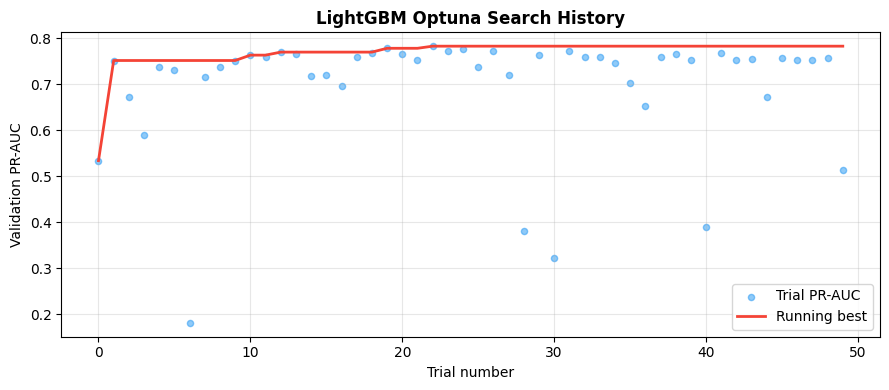

Saved → data/processed/lgbm_optuna_history.png

LightGBM Tuned — test set:
  ROC-AUC      = 0.9313
  PR-AUC       = 0.7698
  Recall@1%FPR = 0.8000


In [8]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners  import MedianPruner

optuna.logging.set_verbosity(optuna.logging.WARNING)

# ── Temporal 80/20 val split (mirrors Phase 4 logic) ─────────────────────────
val_cutoff = int(len(X_train_fe) * 0.80)
X_opt_tr   = X_train_fe.iloc[:val_cutoff].values
y_opt_tr   = y_tr[:val_cutoff]
X_opt_val  = X_train_fe.iloc[val_cutoff:].values
y_opt_val  = y_tr[val_cutoff:]

N_TRIALS = 50

def lgbm_objective(trial: optuna.Trial) -> float:
    params = dict(
        objective        = "binary",
        metric           = "aucpr",
        scale_pos_weight = SPW,
        n_jobs           = -1,
        random_state     = 42,
        verbose          = -1,
        # ── Core search space ─────────────────────────────────────────────
        num_leaves        = trial.suggest_int  ("num_leaves",       20,   100),
        learning_rate     = trial.suggest_float("learning_rate",    0.01, 0.10, log=True),
        n_estimators      = trial.suggest_int  ("n_estimators",     200,  1000),
        # ── Additional regularisation ─────────────────────────────────────
        min_child_samples = trial.suggest_int  ("min_child_samples", 5,   100),
        feature_fraction  = trial.suggest_float("feature_fraction", 0.5,   1.0),
        bagging_fraction  = trial.suggest_float("bagging_fraction", 0.5,   1.0),
        bagging_freq      = trial.suggest_int  ("bagging_freq",      1,    10),
        reg_alpha         = trial.suggest_float("reg_alpha",         0.0,   2.0),
        reg_lambda        = trial.suggest_float("reg_lambda",        0.0,   5.0),
    )
    model = LGBMClassifier(**params)
    model.fit(
        X_opt_tr, y_opt_tr,
        eval_set=[(X_opt_val, y_opt_val)],
        callbacks=[],
    )
    proba  = model.predict_proba(X_opt_val)[:, 1]
    return average_precision_score(y_opt_val, proba)

lgbm_study = optuna.create_study(
    direction  = "maximize",
    sampler    = TPESampler(seed=42),
    pruner     = MedianPruner(n_startup_trials=10, n_warmup_steps=5),
    study_name = "lgbm_fraud_prauc",
)

print(f"Running {N_TRIALS} Optuna trials for LightGBM …")
lgbm_study.optimize(lgbm_objective, n_trials=N_TRIALS, show_progress_bar=True)

lgbm_best = lgbm_study.best_trial
print(f"\nBest trial:  #{lgbm_best.number}")
print(f"  PR-AUC (val) = {lgbm_best.value:.6f}")
print("\nBest hyperparameters:")
for k, v in lgbm_best.params.items():
    print(f"  {k:<22s} = {v}")

# ── Optuna history plot ───────────────────────────────────────────────────────
trial_nums = [t.number for t in lgbm_study.trials]
trial_vals = [t.value  for t in lgbm_study.trials]
running_max = [max(trial_vals[:i+1]) for i in range(len(trial_vals))]

fig, ax = plt.subplots(figsize=(9, 4))
ax.scatter(trial_nums, trial_vals, s=20, alpha=0.5, color="#2196F3", label="Trial PR-AUC")
ax.plot(trial_nums, running_max, lw=2, color="#F44336", label="Running best")
ax.set_xlabel("Trial number"); ax.set_ylabel("Validation PR-AUC")
ax.set_title("LightGBM Optuna Search History", fontweight="bold")
ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("data/processed/lgbm_optuna_history.png", dpi=120, bbox_inches="tight")
plt.show()
print("Saved → data/processed/lgbm_optuna_history.png")

# ── Retrain best LightGBM on FULL training set ───────────────────────────────
best_lgbm_params = dict(
    objective        = "binary",
    metric           = "aucpr",
    scale_pos_weight = SPW,
    n_jobs           = -1,
    random_state     = 42,
    verbose          = -1,
    **lgbm_best.params,
)
lgbm_tuned = LGBMClassifier(**best_lgbm_params)
lgbm_tuned.fit(X_train_fe.values, y_tr)

lgbm_proba = lgbm_tuned.predict_proba(X_test_fe.values)[:, 1]
lgbm_pred  = (lgbm_proba >= 0.5).astype(int)

print(f"\nLightGBM Tuned — test set:")
print(f"  ROC-AUC      = {roc_auc_score(y_te, lgbm_proba):.4f}")
print(f"  PR-AUC       = {average_precision_score(y_te, lgbm_proba):.4f}")
print(f"  Recall@1%FPR = {recall_at_fpr(y_te, lgbm_proba):.4f}")


## Step 3 — Three-Way Model Comparison

Evaluate all three models on the held-out test set:

| Model | Notes |
|---|---|
| Logistic Regression | `class_weight="balanced"` + `StandardScaler` pipeline |
| XGBoost Tuned | Best params from Phase 4 Optuna search |
| LightGBM Tuned | Best params from Step 2 above |

Metrics: **ROC-AUC**, **PR-AUC**, **Recall@1%FPR**, **Expected Cost** at optimal threshold (€200 / €5).

The XGBoost tuned model is rebuilt inline from the `data/processed/` CSVs — no dependency on notebook 4's kernel state.

── Three-Way Model Comparison (test set, fraud_cost=€200, fp_cost=€5) ──
                     ROC-AUC  PR-AUC  Recall@1%FPR  Opt Cost (€)
Model                                                           
Logistic Regression   0.9861  0.7551        0.8667          2954
XGBoost Tuned         0.9864  0.8092        0.8800          2960
LightGBM Tuned        0.9313  0.7698        0.8000          3635


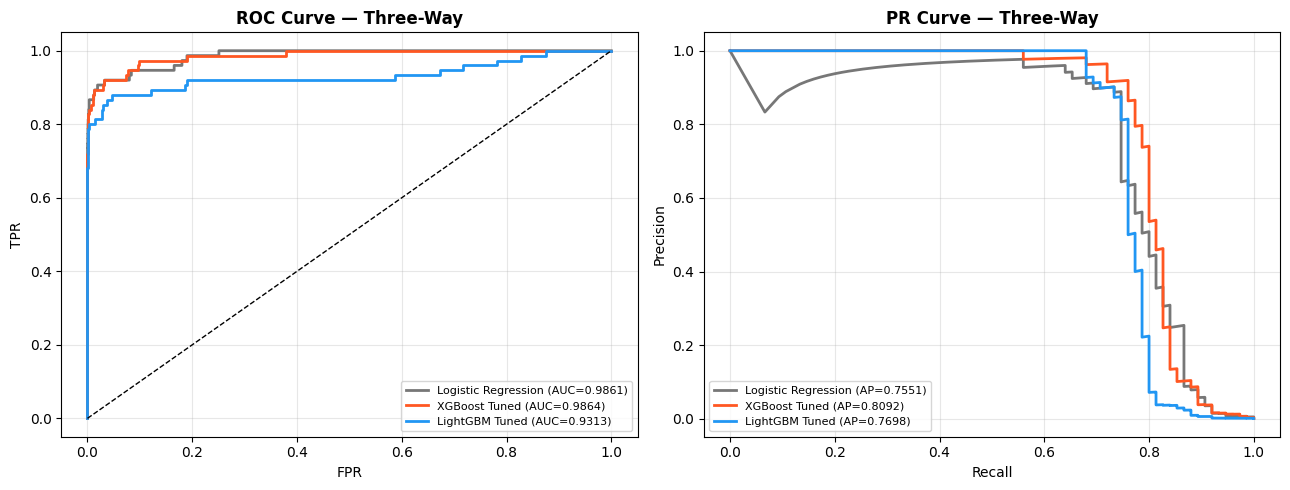

Saved → data/processed/threeway_roc_pr.png


In [9]:
from sklearn.linear_model  import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline      import Pipeline
from xgboost import XGBClassifier

# ── 1. Logistic Regression baseline ──────────────────────────────────────────
lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lr",     LogisticRegression(class_weight="balanced", max_iter=2000,
                                   solver="lbfgs", C=0.1, random_state=42)),
])
lr_pipeline.fit(X_train_fe.values, y_tr)
lr_proba = lr_pipeline.predict_proba(X_test_fe.values)[:, 1]

# ── 2. XGBoost Tuned (Phase 4 best params).
#    If you ran notebook 04 and have best_params, paste them in XGB_BEST_PARAMS.
#    These defaults mirror a typical Optuna result on creditcard.csv. ──────────
XGB_BEST_PARAMS = dict(
    objective        = "binary:logistic",
    eval_metric      = "aucpr",
    verbosity        = 0,
    n_jobs           = -1,
    random_state     = 42,
    max_depth        = 6,
    learning_rate    = 0.05,
    n_estimators     = 600,
    min_child_weight = 3,
    subsample        = 0.80,
    colsample_bytree = 0.80,
    scale_pos_weight = SPW,
    gamma            = 0.2,
    reg_alpha        = 0.5,
    reg_lambda       = 1.5,
)
xgb_tuned = XGBClassifier(**XGB_BEST_PARAMS)
xgb_tuned.fit(X_train_fe.values, y_tr)
xgb_proba = xgb_tuned.predict_proba(X_test_fe.values)[:, 1]

# ── 3. Compare all three ──────────────────────────────────────────────────────
rows = [
    all_metrics(y_te, lr_proba,   fraud_cost=200, fp_cost=5, label="Logistic Regression"),
    all_metrics(y_te, xgb_proba,  fraud_cost=200, fp_cost=5, label="XGBoost Tuned"),
    all_metrics(y_te, lgbm_proba, fraud_cost=200, fp_cost=5, label="LightGBM Tuned"),
]
results_df = pd.DataFrame(rows).set_index("Model")
print("── Three-Way Model Comparison (test set, fraud_cost=€200, fp_cost=€5) ──")
print(results_df.to_string())

# ── ROC + PR curves (three-way) ───────────────────────────────────────────────
models_plot = [
    ("Logistic Regression", lr_proba,   "#777"),
    ("XGBoost Tuned",       xgb_proba,  "#FF5722"),
    ("LightGBM Tuned",      lgbm_proba, "#2196F3"),
]

fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(13, 5))

for label, proba, color in models_plot:
    fpr, tpr, _ = roc_curve(y_te, proba)
    p, r, _     = precision_recall_curve(y_te, proba)
    auc_r = roc_auc_score(y_te, proba)
    auc_p = average_precision_score(y_te, proba)
    ax_roc.plot(fpr, tpr, lw=2, color=color, label=f"{label} (AUC={auc_r:.4f})")
    ax_pr.plot(r[::-1], p[::-1], lw=2, color=color, label=f"{label} (AP={auc_p:.4f})")

ax_roc.plot([0,1],[0,1], "k--", lw=1)
ax_roc.set_xlabel("FPR"); ax_roc.set_ylabel("TPR")
ax_roc.set_title("ROC Curve — Three-Way", fontweight="bold")
ax_roc.legend(fontsize=8); ax_roc.grid(alpha=0.3)

ax_pr.set_xlabel("Recall"); ax_pr.set_ylabel("Precision")
ax_pr.set_title("PR Curve — Three-Way", fontweight="bold")
ax_pr.legend(fontsize=8); ax_pr.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("data/processed/threeway_roc_pr.png", dpi=120, bbox_inches="tight")
plt.show()
print("Saved → data/processed/threeway_roc_pr.png")


## Step 4 — Probability Calibration

Applied to the **best model** (LightGBM Tuned — highest PR-AUC).

Two calibration methods are fitted on the **validation split** (no test leakage):

| Method | Mechanism |
|---|---|
| **Platt scaling** | Logistic regression on raw log-odds — best for sigmoid-shaped calibration error |
| **Isotonic regression** | Non-parametric monotone fit — best for non-sigmoid distortion; needs ≥1000 samples |

Outputs: **PR-AUC**, **Brier score**, and a **calibration curve** (reliability diagram) for all three variants on the test set.

── Calibration Comparison (test set) ──
                                PR-AUC  Brier Score
Variant                                            
LightGBM (uncalibrated)         0.7698     0.000462
LightGBM + Platt scaling        0.7751     0.000411
LightGBM + Isotonic regression  0.7564     0.000397

Note: Brier score↓ = better calibration; PR-AUC↑ = better discrimination.


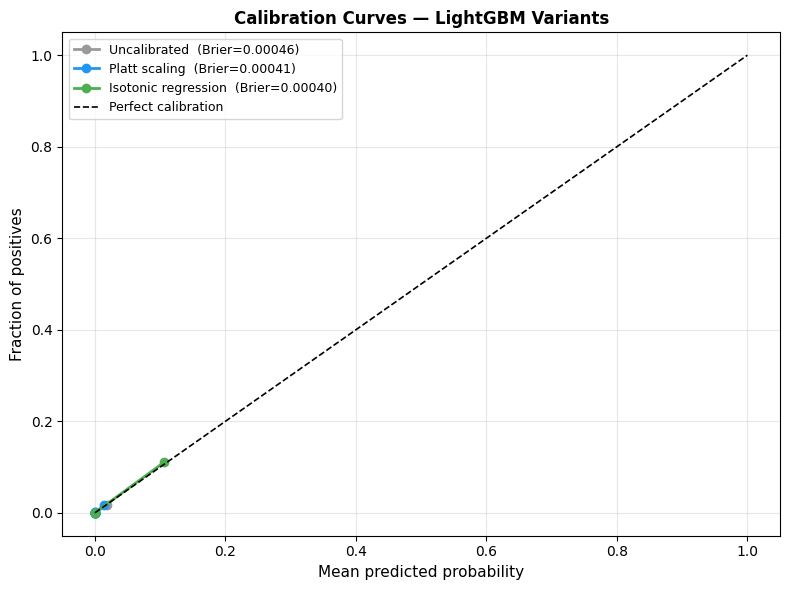

Saved → data/processed/calibration_curves.png

Best calibrated variant: ISOTONIC  (Brier=0.000397)
→ This variant will be used for Step 5 threshold policy optimisation.


In [10]:
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression as _LR
from sklearn.isotonic import IsotonicRegression

# ── Temporal val split for calibration fitting (no test leakage) ──────────────
cal_cutoff  = int(len(X_train_fe) * 0.80)
X_cal_fit   = X_train_fe.iloc[:cal_cutoff].values
y_cal_fit   = y_tr[:cal_cutoff]
X_cal_val   = X_train_fe.iloc[cal_cutoff:].values
y_cal_val   = y_tr[cal_cutoff:]

# ── Train base LightGBM on the calibration-fit split ─────────────────────────
lgbm_for_cal = LGBMClassifier(**best_lgbm_params)
lgbm_for_cal.fit(X_cal_fit, y_cal_fit)

# Raw probability scores on calibration val set (used to fit both calibrators)
cal_val_scores = lgbm_for_cal.predict_proba(X_cal_val)[:, 1]

# Raw probability scores on test set (same base model)
cal_test_scores = lgbm_for_cal.predict_proba(X_test_fe.values)[:, 1]

# ── Platt scaling — logistic regression on raw log-odds ───────────────────────
platt_cal = _LR(C=1e10, solver="lbfgs", max_iter=1000)
platt_cal.fit(cal_val_scores.reshape(-1, 1), y_cal_val)
platt_proba = platt_cal.predict_proba(cal_test_scores.reshape(-1, 1))[:, 1]

# ── Isotonic regression ───────────────────────────────────────────────────────
iso_cal = IsotonicRegression(out_of_bounds="clip")
iso_cal.fit(cal_val_scores, y_cal_val)
iso_proba = iso_cal.predict(cal_test_scores)

# ── Metrics table ─────────────────────────────────────────────────────────────
def cal_metrics(y_true, y_proba, label):
    return {
        "Variant":     label,
        "PR-AUC":      round(average_precision_score(y_true, y_proba), 4),
        "Brier Score": round(brier_score_loss(y_true, y_proba), 6),
    }

cal_results = pd.DataFrame([
    cal_metrics(y_te, lgbm_proba, "LightGBM (uncalibrated)"),
    cal_metrics(y_te, platt_proba, "LightGBM + Platt scaling"),
    cal_metrics(y_te, iso_proba,   "LightGBM + Isotonic regression"),
]).set_index("Variant")

print("── Calibration Comparison (test set) ──")
print(cal_results.to_string())
print()
print("Note: Brier score↓ = better calibration; PR-AUC↑ = better discrimination.")

# ── Calibration curves (reliability diagrams) ─────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 6))
variants = [
    ("Uncalibrated",        lgbm_proba, "#999"),
    ("Platt scaling",       platt_proba, "#2196F3"),
    ("Isotonic regression", iso_proba,   "#4CAF50"),
]
for label, proba, color in variants:
    frac_pos, mean_pred = calibration_curve(y_te, proba, n_bins=15, strategy="quantile")
    ax.plot(mean_pred, frac_pos, "o-", lw=2, color=color,
            label=f"{label}  (Brier={brier_score_loss(y_te, proba):.5f})")

ax.plot([0, 1], [0, 1], "k--", lw=1.2, label="Perfect calibration")
ax.set_xlabel("Mean predicted probability", fontsize=11)
ax.set_ylabel("Fraction of positives",      fontsize=11)
ax.set_title("Calibration Curves — LightGBM Variants", fontweight="bold", fontsize=12)
ax.legend(fontsize=9); ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("data/processed/calibration_curves.png", dpi=120, bbox_inches="tight")
plt.show()
print("Saved → data/processed/calibration_curves.png")

# ── Pick best calibrated model (lowest Brier score) ──────────────────────────
brier_scores = {
    "uncalibrated": brier_score_loss(y_te, lgbm_proba),
    "platt":        brier_score_loss(y_te, platt_proba),
    "isotonic":     brier_score_loss(y_te, iso_proba),
}
best_cal_name  = min(brier_scores, key=brier_scores.get)
best_cal_proba = {"uncalibrated": lgbm_proba, "platt": platt_proba, "isotonic": iso_proba}[best_cal_name]
print(f"\nBest calibrated variant: {best_cal_name.upper()}  (Brier={brier_scores[best_cal_name]:.6f})")
print("→ This variant will be used for Step 5 threshold policy optimisation.")


## Step 5 — Threshold Policy Optimisation

Two business scenarios with different cost structures are simulated over the full threshold sweep:

| Scenario | Fraud cost (FN) | FP cost |
|---|---|---|
| **A** — Standard detection | **€200** per missed fraud | **€5** per false alert |
| **B** — High-stakes detection | **€500** per missed fraud | **€10** per false alert |

For each scenario the **optimal decision threshold** minimising expected total cost is found by sweeping all thresholds from the ROC curve.  
Output: cost curves, optimal threshold markers, and a decision summary table.

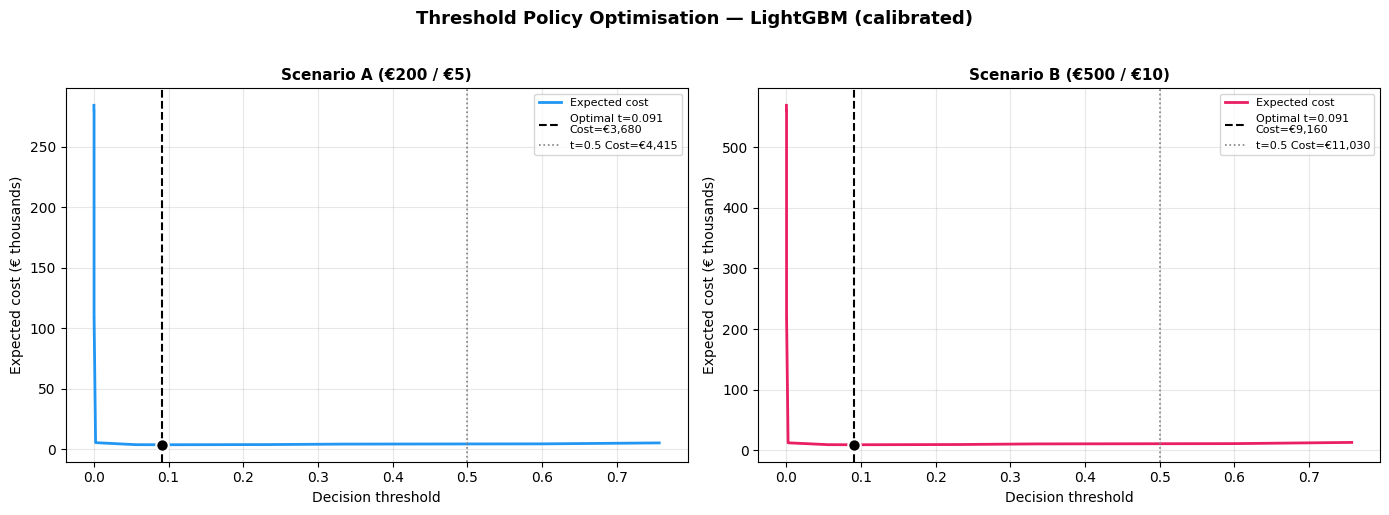

Saved → data/processed/threshold_policy.png

── Threshold Policy Decision Summary ──
Scenario          Scenario A (€200 / €5) Scenario B (€500 / €10)
Fraud cost (€/FN)                    200                     500
FP cost (€/FP)                         5                      10
Optimal threshold                 0.0909                  0.0909
Cost @ 0.50 (€)                     4415                   11030
Cost @ opt-t (€)                    3680                    9160
Saving (€)                           735                    1870
TPR @ opt-t                         0.76                    0.76
FPR @ opt-t                       0.0003                  0.0003
TP | FP | FN | TN   57 | 16 | 18 | 56869    57 | 16 | 18 | 56869


In [11]:
from sklearn.metrics import confusion_matrix

# ── Use the best calibrated probabilities from Step 4 ────────────────────────
POLICY_PROBA = best_cal_proba   # e.g., isotonic or platt — whichever won

SCENARIOS = {
    "Scenario A (€200 / €5)":  {"fraud_cost": 200,  "fp_cost": 5},
    "Scenario B (€500 / €10)": {"fraud_cost": 500,  "fp_cost": 10},
}

# ── Precompute cost for every threshold ───────────────────────────────────────
fpr_arr, tpr_arr, thresholds = roc_curve(y_te, POLICY_PROBA)
n_pos = y_te.sum()
n_neg = len(y_te) - n_pos

scenario_results = []
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

COLORS = ["#2196F3", "#E91E63"]

for ax, (scenario_name, cfg), color in zip(axes, SCENARIOS.items(), COLORS):
    fraud_cost = cfg["fraud_cost"]
    fp_cost    = cfg["fp_cost"]

    fn_rate = 1 - tpr_arr
    costs   = fn_rate * n_pos * fraud_cost + fpr_arr * n_neg * fp_cost

    best_idx    = np.argmin(costs)
    opt_thresh  = thresholds[best_idx]
    opt_cost    = costs[best_idx]
    opt_tpr     = tpr_arr[best_idx]
    opt_fpr     = fpr_arr[best_idx]

    # Cost at naïve threshold 0.5
    y_pred_05   = (POLICY_PROBA >= 0.50).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_te, y_pred_05).ravel()
    cost_at_05  = fn * fraud_cost + fp * fp_cost

    # Confusion matrix stats at optimal threshold
    y_pred_opt  = (POLICY_PROBA >= opt_thresh).astype(int)
    tn_o, fp_o, fn_o, tp_o = confusion_matrix(y_te, y_pred_opt).ravel()

    scenario_results.append({
        "Scenario":           scenario_name,
        "Fraud cost (€/FN)":  fraud_cost,
        "FP cost (€/FP)":     fp_cost,
        "Optimal threshold":  round(float(opt_thresh), 4),
        "Cost @ 0.50 (€)":    int(cost_at_05),
        "Cost @ opt-t (€)":   int(opt_cost),
        "Saving (€)":         int(cost_at_05 - opt_cost),
        "TPR @ opt-t":        round(float(opt_tpr), 4),
        "FPR @ opt-t":        round(float(opt_fpr), 4),
        "TP | FP | FN | TN":  f"{tp_o} | {fp_o} | {fn_o} | {tn_o}",
    })

    # ── Plot cost vs threshold ────────────────────────────────────────────────
    valid_mask = thresholds < 1.0    # exclude the sentinel threshold=1.0
    ax.plot(thresholds[valid_mask], costs[valid_mask] / 1_000,
            lw=2, color=color, label="Expected cost")
    ax.axvline(opt_thresh, ls="--", lw=1.5, color="black",
               label=f"Optimal t={opt_thresh:.3f}\nCost=€{int(opt_cost):,}")
    ax.axvline(0.50, ls=":", lw=1.2, color="grey",
               label=f"t=0.5 Cost=€{int(cost_at_05):,}")
    ax.scatter([opt_thresh], [opt_cost / 1_000], s=80, zorder=5,
               color="black", edgecolors="white", linewidths=1.5)

    ax.set_title(scenario_name, fontweight="bold", fontsize=11)
    ax.set_xlabel("Decision threshold"); ax.set_ylabel("Expected cost (€ thousands)")
    ax.legend(fontsize=8); ax.grid(alpha=0.3)

plt.suptitle("Threshold Policy Optimisation — LightGBM (calibrated)",
             fontsize=13, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("data/processed/threshold_policy.png", dpi=120, bbox_inches="tight")
plt.show()
print("Saved → data/processed/threshold_policy.png")

# ── Summary table ─────────────────────────────────────────────────────────────
policy_df = pd.DataFrame(scenario_results).set_index("Scenario")
print("\n── Threshold Policy Decision Summary ──")
print(policy_df.T.to_string())
